# Data

## Tool Packages

### Transform.py

In [1]:
# encoding:utf-8

import random
import math
import numpy as np
import numbers
import collections
import cv2
import torch
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as F


# ==================================================================================================
# Transforms have been borrowed from https://github.com/hszhao/semseg/blob/master/util/py
# ==================================================================================================
PARAMETER_MAX = 10


class Compose(object):
    def __init__(self, segtransform):
        self.segtransform = segtransform

    def __call__(self, image, label=None):
        if label is None:
            for t in self.segtransform:
                image = t(image, None)
            return image
        else:
            for t in self.segtransform:
                image, label = t(image, label)
            return image, label


class ToTensorPIL(object):
    # Converts numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W).
    def __call__(self, image, label):
        image = transforms.ToTensor()(image)

        if label is not None:
            if not isinstance(label, np.ndarray):
                raise (RuntimeError("segtransform.ToTensor() only handle np.ndarray"
                                    "[eg: data readed by cv2.imread()].\n"))
            if not len(label.shape) == 2:
                raise (RuntimeError(
                    "segtransform.ToTensor() only handle np.ndarray labellabel with 2 dims.\n"))
            label = torch.from_numpy(label)
            if not isinstance(label, torch.LongTensor):
                label = label.long()
            return image, label
        else:
            return image


class ToTensor(object):
    # Converts numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W).
    def __call__(self, image, label):
        if not isinstance(image, np.ndarray):
            raise (RuntimeError("segtransform.ToTensor() only handle np.ndarray"
                                "[eg: data readed by cv2.imread()].\n"))
        if len(image.shape) > 3 or len(image.shape) < 2:
            raise (RuntimeError(
                "segtransform.ToTensor() only handle np.ndarray with 3 dims or 2 dims.\n"))
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=2)

        image = torch.from_numpy(image.transpose((2, 0, 1)))
        if not isinstance(image, torch.FloatTensor):
            image = image.float().div(255)
        if label is not None:
            if not isinstance(label, np.ndarray):
                raise (RuntimeError("segtransform.ToTensor() only handle np.ndarray"
                                    "[eg: data readed by cv2.imread()].\n"))
            if not len(label.shape) == 2:
                raise (RuntimeError(
                    "segtransform.ToTensor() only handle np.ndarray labellabel with 2 dims.\n"))
            label = torch.from_numpy(label)
            if not isinstance(label, torch.LongTensor):
                label = label.long()
            return image, label
        else:
            return image


class Normalize(object):
    # Normalize tensor with mean and standard deviation along channel: channel = (channel - mean) / std
    def __init__(self, mean, std=None):
        if std is None:
            assert len(mean) > 0
        else:
            assert len(mean) == len(std)
        self.mean = mean
        self.std = std

    def __call__(self, image, label):
        if self.std is None:
            for t, m in zip(image, self.mean):
                t.sub_(m)
        else:
            for t, m, s in zip(image, self.mean, self.std):
                t.sub_(m).div_(s)
        if label is not None:
            return image, label
        else:
            return image


class Resize(object):
    # Resize the input to the given size, 'size' is a 2-element tuple or list in the order of (h, w).
    def __init__(self, size, padding=None):
        self.size = size
        self.padding = padding

    def __call__(self, image, label):

        def find_new_hw(ori_h, ori_w, test_size):
            if ori_h >= ori_w:
                ratio = test_size * 1.0 / ori_h
                new_h = test_size                 # test_size is target_size
                new_w = int(ori_w * ratio)
            elif ori_w > ori_h:
                ratio = test_size * 1.0 / ori_w
                new_h = int(ori_h * ratio)
                new_w = test_size

            if new_h % 8 != 0:
                new_h = (int(new_h / 8)) * 8   # 为什么新的长宽是8的倍数
            else:
                new_h = new_h
            if new_w % 8 != 0:
                new_w = (int(new_w / 8)) * 8
            else:
                new_w = new_w
            return new_h, new_w

        # Step 1: resize while keeping the h/w ratio. The largest side (i.e height or width) is reduced to $size.
        #                                             The other is reduced accordingly
        test_size = self.size
        new_h, new_w = find_new_hw(image.shape[0], image.shape[1], test_size)

        image_crop = cv2.resize(image, dsize=(int(new_w), int(new_h)),
                                interpolation=cv2.INTER_LINEAR)

        # Step 2: Pad wtih 0 whatever needs to be padded to get a ($size, $size) image
        back_crop = np.zeros((test_size, test_size, 3))
        if self.padding:
            back_crop[:, :, 0] = self.padding[0]
            back_crop[:, :, 1] = self.padding[1]
            back_crop[:, :, 2] = self.padding[2]
        back_crop[:new_h, :new_w, :] = image_crop
        image = back_crop

        # Step 3: Do the same for the label (the padding is 255)
        if label is not None:
            s_mask = label
            new_h, new_w = find_new_hw(
                s_mask.shape[0], s_mask.shape[1], test_size)
            s_mask = cv2.resize(s_mask.astype(np.float32), dsize=(int(new_w), int(new_h)),
                                interpolation=cv2.INTER_NEAREST)
            back_crop_s_mask = np.ones((test_size, test_size)) * 255
            back_crop_s_mask[:new_h, :new_w] = s_mask
            label = back_crop_s_mask

            return image, label
        else:
            return image, new_h, new_w


class Resize_np(object):
    # Resize the input to the given size, 'size' is a 2-element tuple or list in the order of (h, w).
    def __init__(self, size):
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size

    def __call__(self, image, label):

        # resize image
        # F.resize(image, self.size, self.interpolation)
        image = cv2.resize(image, dsize=self.size,
                           interpolation=cv2.INTER_LINEAR)
        image = image.astype(np.int)
        # resize the label
        label = cv2.resize(label.astype(np.float32),
                           dsize=self.size, interpolation=cv2.INTER_NEAREST)

        return image, label


class RandScale(object):
    # Randomly resize image & label with scale factor in [scale_min, scale_max]
    def __init__(self, scale, aspect_ratio=None, fixed_size=None, padding=None):
        assert (isinstance(scale, collections.Iterable) and len(scale) == 2)
        if isinstance(scale[0], numbers.Number) \
                and isinstance(scale[1], numbers.Number) \
                and 0 < scale[0] < scale[1]:
            self.scale = scale               # scale = (0.5, 1.5)
        else:
            raise (RuntimeError("segRandScale() scale param error.\n"))

        if aspect_ratio is None:
            self.aspect_ratio = aspect_ratio
        elif isinstance(aspect_ratio, collections.Iterable) \
                and len(aspect_ratio) == 2 \
                and isinstance(aspect_ratio[0], numbers.Number) \
                and isinstance(aspect_ratio[1], numbers.Number) \
                and 0 < aspect_ratio[0] < aspect_ratio[1]:
            self.aspect_ratio = aspect_ratio
        else:
            raise (RuntimeError("segRandScale() aspect_ratio param error.\n"))

        self.fixed_size, self.padding = fixed_size, padding

    def __call__(self, image, label):
        # 从 scale[0] 到 scale[1]随机选取一个scale
        temp_scale = self.scale[0] + \
            (self.scale[1] - self.scale[0]) * random.random()
        temp_aspect_ratio = 1.0
        if self.aspect_ratio is not None:
            temp_aspect_ratio = self.aspect_ratio[0] + (
                self.aspect_ratio[1] - self.aspect_ratio[0]) * random.random()
            temp_aspect_ratio = math.sqrt(temp_aspect_ratio)
        scale_factor_x = temp_scale * temp_aspect_ratio
        scale_factor_y = temp_scale / temp_aspect_ratio
        image = cv2.resize(image, None, fx=scale_factor_x, fy=scale_factor_y,
                           interpolation=cv2.INTER_LINEAR)
        label = cv2.resize(label, None, fx=scale_factor_x, fy=scale_factor_y,
                           interpolation=cv2.INTER_NEAREST)

        if self.fixed_size is not None and self.fixed_size > 0:
            new_h, new_w, _ = image.shape

            back_crop = np.zeros((self.fixed_size, self.fixed_size, 3))
            if self.padding:
                back_crop[:, :, 0] = self.padding[0]
                back_crop[:, :, 1] = self.padding[1]
                back_crop[:, :, 2] = self.padding[2]
            back_crop[:new_h, :new_w, :] = image
            image = back_crop

            back_crop_mask = np.ones((self.fixed_size, self.fixed_size)) * 255
            back_crop_mask[:new_h, :new_w] = label
            label = back_crop_mask

        return image, label


class Crop(object):
    """Crops the given ndarray image (H*W*C or H*W).
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
        int instead of sequence like (h, w), a square crop (size, size) is made.
    """

    def __init__(self, size, crop_type='center', padding=None, ignore_label=255):
        if isinstance(size, int):
            self.crop_h = size
            self.crop_w = size
        elif isinstance(size, collections.Iterable) and len(size) == 2 \
                and isinstance(size[0], int) and isinstance(size[1], int) \
                and size[0] > 0 and size[1] > 0:
            self.crop_h = size[0]
            self.crop_w = size[1]
        else:
            raise (RuntimeError("crop size error.\n"))
        if crop_type == 'center' or crop_type == 'rand':
            self.crop_type = crop_type
        else:
            raise (RuntimeError("crop type error: rand | center\n"))
        if padding is None:
            self.padding = padding
        elif isinstance(padding, list):
            if all(isinstance(i, numbers.Number) for i in padding):
                self.padding = padding
            else:
                raise (RuntimeError("padding in Crop() should be a number list\n"))
            if len(padding) != 3:
                raise (RuntimeError("padding channel is not equal with 3\n"))
        else:
            raise (RuntimeError("padding in Crop() should be a number list\n"))
        if isinstance(ignore_label, int):
            self.ignore_label = ignore_label
        else:
            raise (RuntimeError("ignore_label should be an integer number\n"))

    def __call__(self, image, label):
        h, w = image.shape[:2]
        pad_h = max(self.crop_h - h, 0)
        pad_w = max(self.crop_w - w, 0)
        pad_h_half = int(pad_h / 2)
        pad_w_half = int(pad_w / 2)
        if pad_h > 0 or pad_w > 0:
            if self.padding is None:
                raise (RuntimeError(
                    "segtransform.Crop() need padding while padding argument is None\n"))
            image = cv2.copyMakeBorder(image, pad_h_half, pad_h - pad_h_half, pad_w_half,
                                       pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=self.padding)
            # image = np.zeros(3,)
            if label is not None:
                label = cv2.copyMakeBorder(label, pad_h_half, pad_h - pad_h_half, pad_w_half,
                                           pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=self.ignore_label)
        h, w = image.shape[:2]
        if self.crop_type == 'rand':
            h_off = random.randint(0, h - self.crop_h)
            w_off = random.randint(0, w - self.crop_w)
        else:
            h_off = int((h - self.crop_h) / 2)
            w_off = int((w - self.crop_w) / 2)
        image = image[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]
        image = image.astype(np.int)
        if label is not None:
            label = label[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]
            return image, label
        else:
            return image


class FitCrop(object):
    """Crops the given ndarray image (H*W*C or H*W).
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
        int instead of sequence like (h, w), a square crop (size, size) is made.
    """

    def __init__(self, k=2, multi=False):
        self.k = k  # whether to crop at 1/2 or 1/3,  if fg is very small portion, will cutoff bigger area
        self.multi = multi  # whether to return multiple cropped image

    def __call__(self, image, label):
        h, w, _ = image.shape

        label_binary = label.copy()
        label_binary[label_binary == 255] = 0
        _, labels = cv2.connectedComponents(label_binary)  # labels 为联通域 的 idx

        freq = np.bincount(labels.flatten())
        freq[0] = 0
        obj_idx = np.argmax(freq)      # id for 最大联通域
        pxl_cnt = freq[obj_idx]
        h0, h1, w0, w1 = self.get_coord(labels, obj_idx, h, w)
        image = image[h0:h1, w0:w1]
        label = label[h0:h1, w0:w1]

        if self.multi and len(freq) >= 3:
            freq[obj_idx] = 0
            obj_idx2 = np.argmax(freq)
            pxl_cnt2 = freq[obj_idx2]

            if pxl_cnt2 / pxl_cnt >= 0.3:
                h0, h1, w0, w1 = self.get_coord(labels, obj_idx2, h, w)
                image2 = image[h0:h1, w0:w1]
                label2 = label[h0:h1, w0:w1]

                return image, label, image2, label2

        return image, label

    def get_coord(self, labels, obj_idx, h, w):
        mask_pos = np.where(labels == obj_idx)
        min_h, max_h, min_w, max_w = np.min(mask_pos[0]), np.max(
            mask_pos[0]), np.min(mask_pos[1]), np.max(mask_pos[1])

        h0, h1 = min_h // self.k, h - (h - max_h) // self.k
        w0, w1 = min_w // self.k, w - (w - max_w) // self.k

        if (h1 - h0) / (w1 - w0) <= 0.7:  # height too small
            if h0 <= h - h1:
                h0 = 0
            else:
                h1 = h
        elif (h1 - h0) / (w1 - w0) >= 1.5:  # width too small
            if w0 <= w - w1:
                w0 = 0
            else:
                w1 = w
        return h0, h1, w0, w1


class RandRotate(object):
    # Randomly rotate image & label with rotate factor in [rotate_min, rotate_max]
    def __init__(self, rotate, padding, ignore_label=255, p=0.5):
        assert (isinstance(rotate, collections.Iterable) and len(rotate) == 2)
        if isinstance(rotate[0], numbers.Number) and isinstance(rotate[1], numbers.Number) \
                and rotate[0] < rotate[1]:
            self.rotate = rotate
        else:
            raise (RuntimeError("segtransform.RandRotate() scale param error.\n"))
        assert padding is not None
        assert isinstance(padding, list) and len(padding) == 3
        if all(isinstance(i, numbers.Number) for i in padding):
            self.padding = padding
        else:
            raise (RuntimeError("padding in RandRotate() should be a number list\n"))
        assert isinstance(ignore_label, int)
        self.ignore_label = ignore_label
        self.p = p

    def __call__(self, image, label):
        if random.random() < self.p:
            angle = self.rotate[0] + \
                (self.rotate[1] - self.rotate[0]) * random.random()
            h, w = label.shape
            matrix = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
            image = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR,
                                   borderMode=cv2.BORDER_CONSTANT, borderValue=self.padding)
            label = cv2.warpAffine(label, matrix, (w, h), flags=cv2.INTER_NEAREST,
                                   borderMode=cv2.BORDER_CONSTANT, borderValue=self.ignore_label)
        return image, label


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, label):
        if random.random() < self.p:
            image = cv2.flip(image, 1)
            label = cv2.flip(label, 1)
        return image, label


class RandomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, label):
        if random.random() < self.p:
            image = cv2.flip(image, 0)
            label = cv2.flip(label, 0)
        return image, label


class RandomGaussianBlur(object):
    def __init__(self, radius=5):
        self.radius = radius

    def __call__(self, image, label):
        if random.random() < 0.5:
            image = cv2.GaussianBlur(image, (self.radius, self.radius), 0)
        return image, label


class ColorJitter(object):
    def __init__(self, cj_type='b'):
        self.cj_type = cj_type

    def __call__(self, img, label):
        '''
        ### Different Color Jitter ###
        img: image
        cj_type: {b: brightness, s: saturation, c: constast}
        '''
        if self.cj_type == "b":
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # Hue, Saturation, and Value (Brightness)
            h, s, v = cv2.split(hsv)
            value = 35 if np.mean(v) <= 125 else -35
            if value >= 0:
                lim = 255 - value
                v[v > lim] = 255
                v[v <= lim] += value
            else:
                lim = np.absolute(value)
                v[v < lim] = 0
                v[v >= lim] -= np.absolute(value)

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        elif self.cj_type == "s":
            # value = random.randint(-50, 50)
            value = np.random.choice(np.array([0.5, 0.75, 1.25, 1.5]))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            s *= value

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        elif self.cj_type == "c":
            brightness = 10
            contrast = random.randint(40, 100)
            dummy = np.int16(img)
            dummy = dummy * (contrast / 127 + 1) - contrast + brightness
            img = np.clip(dummy, 0, 255)

        return img, label


class ColorAug(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        # [max(0, 1 - brightness), 1 + brightness]
        self.brightness = brightness
        # [max(0, 1 - contrast), 1 + contrast]
        self.contrast = contrast
        # [max(0, 1 - saturation), 1 + saturation]
        self.saturation = saturation
        self.hue = hue                                 # [-hue, hue]
        self.gitter = transforms.ColorJitter(
            self.brightness, self.contrast, self.saturation, self.hue)

    def __call__(self, image, label):
        image = Image.fromarray(np.uint8(image)).convert('RGB')
        image = self.gitter(image)
        image = np.array(image)
        return image, label


class Contrast(object):
    def __init__(self, v=0.9, max_v=0.05, bias=0):
        self.v = _float_parameter(v, max_v) + bias

    def __call__(self, image, label):
        image = Image.fromarray(np.uint8(image)).convert('RGB')
        return PIL.ImageEnhance.Contrast(image).enhance(self.v), label


class Brightness(object):
    def __init__(self, v=1.8, max_v=0.1, bias=0):
        self.v = _float_parameter(v, max_v) + bias

    def __call__(self, image, label):
        image = Image.fromarray(np.uint8(image)).convert('RGB')
        return PIL.ImageEnhance.Brightness(image).enhance(self.v), label


class Sharpness(object):
    def __init__(self, v=0.9, max_v=0.05, bias=0):
        self.v = _float_parameter(v, max_v) + bias

    def __call__(self, image, label):
        image = Image.fromarray(np.uint8(image)).convert('RGB')
        return PIL.ImageEnhance.Sharpness(image).enhance(self.v), label


class AutoContrast(object):
    def __call__(self, image, label):
        image = Image.fromarray(np.uint8(image)).convert('RGB')
        return PIL.ImageOps.autocontrast(image), label


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


class RGB2BGR(object):
    # Converts image from RGB order to BGR order, for model initialized from Caffe
    def __call__(self, image, label):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return image, label


class BGR2RGB(object):
    # Converts image from BGR order to RGB order, for model initialized from Pytorch
    def __call__(self, image, label):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image, label


### Utils.py

In [2]:
# encoding:utf-8

import os
import cv2
import numpy as np
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool
from collections import defaultdict
from typing import Callable, Dict, Iterable, List, Tuple, TypeVar


IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']

A = TypeVar("A")
B = TypeVar("B")


def mmap_(fn: Callable[[A], B], iter: Iterable[A]) -> List[B]:
    return Pool().map(fn, iter)


def is_image_file(filename: str) -> bool:
    filename_lower = filename.lower()
    return any(filename_lower.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(
        data_root: str,
        data_list: str,
        class_list: List[int]
) -> Tuple[List[Tuple[str, str]], Dict[int, List[Tuple[str, str]]]]:

    if not os.path.isfile(data_list):
        raise (RuntimeError("Image list file do not exist: " + data_list + "\n"))
    '''
        Recovers all tupples (img_path, label_path) relevant to the current experiments (class_list
        is used as filter)

        input:
            data_root : Path to the data directory
            data_list : Path to the .txt file that contain the train/test split of images
            class_list: List of classes to keep
        returns:
            image_label_list: List of (img_path, label_path) that contain at least 1 object of a class
                              in class_list
            class_file_dict: Dict of all (img_path, label_path that contain at least 1 object of a class
                              in class_list, grouped by classes.
    '''
    image_label_list: List[Tuple[str, str]] = []
    list_read = open(data_list).readlines()

    print(f"Processing data for {class_list}")
    class_file_dict: Dict[int, List[Tuple[str, str]]] = defaultdict(list)

    process_partial = partial(
        process_image, data_root=data_root, class_list=class_list)

    for sublist, subdict in mmap_(process_partial, tqdm(list_read)):
        image_label_list += sublist

        for (k, v) in subdict.items():
            class_file_dict[k] += v

    return image_label_list, class_file_dict
    # image_label_list：list of 所有包含的图片 [(image_filename, label_filename)], class_file_dict：cls_id->相应图片list


def process_image(
        line: str,
        data_root: str,
        class_list: List
) -> Tuple[List, Dict]:
    '''
        Reads and parses a line corresponding to 1 file

        input:
            line : A line corresponding to 1 file, in the format path_to_image.jpg path_to_image.png
            data_root : Path to the data directory
            class_list: List of classes to keep

    '''
    line = line.strip()
    line_split = line.split(' ')
    image_name = os.path.join(data_root, line_split[0])   # image_file
    label_name = os.path.join(data_root, line_split[1])   # label_file
    item: Tuple[str, str] = (image_name, label_name)
    label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)
    label_class = np.unique(label).tolist()                # 当前图片的所有 category

    if 0 in label_class:
        label_class.remove(0)
    if 255 in label_class:
        label_class.remove(255)
    for label_class_ in label_class:
        assert label_class_ in list(range(1, 81)), label_class_

    c: int
    new_label_class = []                                # 选取符合条件, 在meta train中的label
    for c in label_class:
        if c in class_list:                             # 保证cls在当前图片中占有一定的比重
            tmp_label = np.zeros_like(label)
            target_pix = np.where(label == c)          # 返回 row idx 和 col idx
            tmp_label[target_pix[0], target_pix[1]] = 1
            if tmp_label.sum() >= 2 * 32 * 32:
                new_label_class.append(c)

    label_class = new_label_class    # 筛选了当前图片中满足条件（最少有32*32*2个pixel）的所有cls

    image_label_list: List[Tuple[str, str]] = []
    class_file_dict: Dict[int, List[Tuple[str, str]]] = defaultdict(list)

    if len(label_class) > 0:
        image_label_list.append(item)  # item包含 image filename & label filname

        for c in label_class:
            assert c in class_list
            class_file_dict[c].append(item)

    return image_label_list, class_file_dict
    # image_label_list：list of 所有包含的图片, class_file_dict：cls_id->相应图片list: 只针对当前这张图片！


### Classes.py

In [3]:
# encoding:utf-8

import argparse
from collections import defaultdict
from typing import Dict, List, Any

classId2className = {'coco': {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    12: 'stop sign',
    13: 'parking meter',
    14: 'bench',
    15: 'bird',
    16: 'cat',
    17: 'dog',
    18: 'horse',
    19: 'sheep',
    20: 'cow',
    21: 'elephant',
    22: 'bear',
    23: 'zebra',
    24: 'giraffe',
    25: 'backpack',
    26: 'umbrella',
    27: 'handbag',
    28: 'tie',
    29: 'suitcase',
    30: 'frisbee',
    31: 'skis',
    32: 'snowboard',
    33: 'sports ball',
    34: 'kite',
    35: 'baseball bat',
    36: 'baseball glove',
    37: 'skateboard',
    38: 'surfboard',
    39: 'tennis racket',
    40: 'bottle',
    41: 'wine glass',
    42: 'cup',
    43: 'fork',
    44: 'knife',
    45: 'spoon',
    46: 'bowl',
    47: 'banana',
    48: 'apple',
    49: 'sandwich',
    50: 'orange',
    51: 'broccoli',
    52: 'carrot',
    53: 'hot dog',
    54: 'pizza',
    55: 'donut',
    56: 'cake',
    57: 'chair',
    58: 'sofa',
    59: 'pottedplant',
    60: 'bed',
    61: 'diningtable',
    62: 'toilet',
    63: 'tv',
    64: 'laptop',
    65: 'mouse',
    66: 'remote',
    67: 'keyboard',
    68: 'cell phone',
    69: 'microwave',
    70: 'oven',
    71: 'toaster',
    72: 'sink',
    73: 'refrigerator',
    74: 'book',
    75: 'clock',
    76: 'vase',
    77: 'scissors',
    78: 'teddy bear',
    79: 'hair drier',
    80: 'toothbrush'},

    'pascal': {
    1: 'airplane',   # 0.14
    2: 'bicycle',    # 0.07
    3: 'bird',       # 0.13
    4: 'boat',       # 0.12
    5: 'bottle',     # 0.15
    6: 'bus',        # 0.35
    7: 'cat',        # 0.20
    8: 'car',        # 0.26
    9: 'chair',      # 0.10
    10: 'cow',       # 0.24
    11: 'diningtable',  # 0.22
    12: 'dog',         # 0.23
    13: 'horse',       # 0.21
    14: 'motorcycle',  # 0.22
    15: 'person',      # 0.20
    16: 'pottedplant',  # 0.11
    17: 'sheep',       # 0.19
    18: 'sofa',        # 0.23
    19: 'train',       # 0.27
    20: 'tv'           # 0.14
}
}

className2classId = defaultdict(dict)
for dataset in classId2className:
    for id in classId2className[dataset]:
        className2classId[dataset][classId2className[dataset][id]] = id


def get_split_classes(args: argparse.Namespace) -> Dict[str, Any]:
    """
    Returns the split of classes for Pascal-5i and Coco-20i
    inputs:
        args

    returns :
         split_classes : Dict.
                         split_classes['coco'][0]['train'] = training classes in fold 0 of Coco-20i
    """
    split_classes = {'coco': defaultdict(dict), 'pascal': defaultdict(dict)}

    # =============== COCO ===================
    name = 'coco'
    class_list = list(range(1, 81))
    # key: coco -> -1 -> val  "split -1 包含所有的class"
    split_classes[name][-1]['val'] = class_list
    if args.use_split_coco:
        vals_lists = [list(range(1, 78, 4)), list(range(2, 79, 4)),
                      list(range(3, 80, 4)), list(range(4, 81, 4))]
        # vals_lists = [[5, 2, 15, 9, 40], [6, 3, 16, 57, 20],
        #               [61, 17, 18, 4, 1], [59, 19, 58, 7, 63]]
        for i, val_list in enumerate(vals_lists):
            split_classes[name][i]['val'] = val_list
            split_classes[name][i]['train'] = list(
                set(class_list) - set(val_list))

    else:
        class_list = list(range(1, 81))
        vals_lists = [list(range(1, 21)), list(range(21, 41)),         # 共80个class,4个split.
                      list(range(41, 61)), list(range(61, 81))]
        for i, val_list in enumerate(vals_lists):
            split_classes[name][i]['val'] = val_list
            split_classes[name][i]['train'] = list(
                set(class_list) - set(val_list))

    # =============== Pascal ===================
    name = 'pascal'
    class_list = list(range(1, 21))
    vals_lists = [list(range(1, 6)), list(range(6, 11)),
                  list(range(11, 16)), list(range(16, 21))]
    split_classes[name][-1]['val'] = class_list
    for i, val_list in enumerate(vals_lists):
        split_classes[name][i]['val'] = val_list
        split_classes[name][i]['train'] = list(set(class_list) - set(val_list))

    return split_classes


def filter_classes(train_name: str,
                   train_split: int,
                   test_name: str,
                   test_split: int,
                   split_classes: Dict) -> List[int]:
    """ Useful for domain shift experiments. Filters out classes that were seen
        during  training (i.e in the train_name dataset) from the current list.

    inputs:
        train_name : 'coco' or 'pascal'
        test_name : 'coco' or 'pascal'
        train_split : In {0, 1, 2, 3}
        test_split : In {0, 1, 2, 3, -1}. -1 represents "all classes" (the one used in our experiments)
        split_classes: Dict of all classes used for each dataset and each split


    returns :
        kept_classes_id : Filtered list of class ids that will be used for testing
    """
    print(f'INFO: {train_name} -> {test_name}')
    print(f'INFO: {train_split} -> {test_split}')
    print(">> Start Filtering classes ")
    seen_classes = [classId2className[train_name][c]
                    for c in split_classes[train_name][train_split]['train']]  # 所有meta train cls name
    # meta_test数据 cls id
    initial_classes = split_classes[test_name][test_split]['val']
    kept_classes_id = []
    removed_classes = []
    kept_classes_name = []
    for c in initial_classes:
        if classId2className[test_name][c] in seen_classes:
            removed_classes.append(classId2className[test_name][c])
        else:
            kept_classes_id.append(c)
            kept_classes_name.append(classId2className[test_name][c])
    print(">> Removed classes = {} ".format(removed_classes))
    print(">> Kept classes = {} ".format(kept_classes_name))
    return kept_classes_id


## Dataset

In [4]:
import cv2
import torch
import random
import argparse
import numpy as np
from typing import List
from torch.utils.data import Dataset
from torchvision import transforms as T
from torch.utils.data.distributed import DistributedSampler


### Standard Data

In [5]:
class StandardData(Dataset):
    def __init__(self, args: argparse.Namespace,
                 transform: Compose,
                 data_list_path: str,
                 class_list: List[int],
                 return_paths: bool):
        # path to dataset directory
        self.data_root = args.data_root
        # dict of containing two dicts (pascal & coco), mapping the classes that corresponds to different dataset splits
        self.class_list = class_list
        # return a tuple with: 1, a List of all (image_path, label_path) Tuples; 2, a Dict mapping (image_path, label_path) Tuples for different classes
        self.data_list, _ = make_dataset(
            args.data_root, data_list_path, class_list)
        # Composed transformation for dataset
        self.transform = transform
        # whether to return image&label path in __getitem__
        self.return_paths = return_paths

        def __len__(self):
            return len(self.data_list)

        def __getitem__(self, index):

            # read image and labels
            image_path, label_path = self.data_list[index]
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.float32(image)
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

            # double check to make sure the shape matches
            if image.shape[0] != label.shape[0] or image.shape[1] != label.shape[1]:
                raise (RuntimeError("Query Image & label shape mismatch: " +
                       image_path + " " + label_path + "\n"))

            # remove unwanted label classes
            label_class = np.unique(label).tolist()
            if 0 in label_class:
                label_class.remove(0)
            if 255 in label_class:
                label_class.remove(255)

            new_label_class = []
            undesired_class = []
            for c in label_class:
                if c in self.class_list:
                    new_label_class.append(c)
                else:
                    undesired_class.append(c)
            label_class = new_label_class
            assert len(label_class) > 0

            # background
            new_label = np.zeros_like(label)
            for lab in label_class:
                indexes = np.where(label == lab)
                new_label[indexes[0], indexes[1]] = self.class_list.index(
                    lab) + 1       # Add 1 because class 0 is for bg
            for lab in undesired_class:
                indexes = np.where(label == lab)
                new_label[indexes[0], indexes[1]] = 255

            if self.transform is not None:
                image, new_label = self.transform(image, new_label)
            if self.return_paths:
                return image, new_label, image_path, label_path
            else:
                return image, new_label


### Episodic Data

In [6]:
class EpisodicData(Dataset):
    def __init__(self,
                 mode_train: bool,
                 dt_transform: Compose,
                 class_list: List[int],
                 args: argparse.Namespace):

        self.shot = args.shot
        self.padding = [
            v*255 for v in args.mean] if args.get('padding') == 'avg' else None
        self.meta_aug = args.get('meta_aug', 0)
        self.aug_th = args.get('aug_th', [0.15, 0.30])
        self.aug_type = args.get('aug_type', 0)
        self.args = args

        self.random_shot = args.random_shot
        self.data_root = args.data_root
        self.class_list = class_list
        if mode_train:    # args.train_list： txt file 存储 pascal 中所有train_split的file
            self.data_list, self.sub_class_file_list = make_dataset(
                args.data_root, args.train_list, self.class_list)
        else:
            self.data_list, self.sub_class_file_list = make_dataset(
                args.data_root, args.val_list, self.class_list)
        self.transform = dt_transform

        print(
            f"Augmenting data using the following setting {args.get('brightness', 0)}{args.get('contrast', 0)}{args.get('saturation', 0)}{args.get('hue', 0)}")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        # ====== Read query image + Chose class ======
        image_path, label_path = self.data_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if image.shape[0] != label.shape[0] or image.shape[1] != label.shape[1]:
            raise (RuntimeError("Query Image & label shape mismatch: " +
                   image_path + " " + label_path + "\n"))
        label_class = np.unique(label).tolist()
        if 0 in label_class:
            label_class.remove(0)
        if 255 in label_class:
            label_class.remove(255)
        new_label_class = []
        for c in label_class:
            if c in self.class_list:                                                 # current list of classes to try
                new_label_class.append(c)
        label_class = new_label_class
        # 只选取 满足 train/test split的class
        assert len(label_class) > 0

        # ====== From classes in query image, chose one randomly ======
        class_chosen = np.random.choice(label_class)
        new_label = np.zeros_like(label)
        ignore_pix = np.where(label == 255)
        target_pix = np.where(label == class_chosen)
        new_label[ignore_pix] = 255
        new_label[target_pix] = 1
        label = new_label

        # 当前split 选取的class, 所对应的image/label path
        file_class_chosen = self.sub_class_file_list[class_chosen]
        num_file = len(file_class_chosen)

        # ====== Build support ======
        # First, randomly choose indexes of support images
        support_image_path_list = []
        support_label_path_list = []
        support_idx_list = []

        if self.random_shot:
            shot = random.randint(1, self.shot)
        else:
            shot = self.shot

        for k in range(shot):
            support_idx = random.randint(1, num_file) - 1
            support_image_path = image_path
            support_label_path = label_path
            while(
                (support_image_path == image_path and support_label_path == label_path)
                or
                (support_idx in support_idx_list)
            ):                                                                     # 排除 query img 并确保 support image(s) 没有重复
                support_idx = random.randint(1, num_file) - 1
                support_image_path, support_label_path = file_class_chosen[support_idx]
            support_idx_list.append(support_idx)
            support_image_path_list.append(support_image_path)
            support_label_path_list.append(support_label_path)

        support_image_list = []
        support_label_list = []
        subcls_list = [self.class_list.index(class_chosen) + 1]

        # Second, read support images and masks
        for k in range(shot):
            support_image_path = support_image_path_list[k]
            support_label_path = support_label_path_list[k]
            support_image = cv2.imread(support_image_path, cv2.IMREAD_COLOR)
            support_image = cv2.cvtColor(support_image, cv2.COLOR_BGR2RGB)
            support_image = np.float32(support_image)
            support_label = cv2.imread(
                support_label_path, cv2.IMREAD_GRAYSCALE)
            target_pix = np.where(support_label == class_chosen)
            ignore_pix = np.where(support_label == 255)
            support_label[:, :] = 0
            support_label[target_pix[0], target_pix[1]] = 1
            support_label[ignore_pix[0], ignore_pix[1]] = 255
            if support_image.shape[0] != support_label.shape[0] or support_image.shape[1] != support_label.shape[1]:
                raise (
                    RuntimeError("Support Image & label shape mismatch: "
                                 + support_image_path + " " + support_label_path + "\n")
                )
            support_image_list.append(support_image)
            support_label_list.append(support_label)
        assert len(support_label_list) == shot and len(
            support_image_list) == shot

        # Original support images and labels
        support_images = support_image_list.copy()
        support_labels = support_label_list.copy()

        # ============== Forward images through transforms
        if self.transform is not None:
            qry_img, target = self.transform(
                image, label)    # transform query img
            for k in range(shot):                             # transform support img
                if self.meta_aug > 1:
                    org_img, org_label = self.transform(
                        support_image_list[k], support_label_list[k])  # flip and resize
                    label_freq = np.bincount(support_label_list[k].flatten())
                    fg_ratio = label_freq[1] / np.sum(label_freq)

                    if self.aug_type == 0:
                        new_img, new_label = self.get_aug_data0(
                            fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 1:
                        new_img, new_label = self.get_aug_data1(
                            fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 3:
                        new_img, new_label = self.get_aug_data3(
                            fg_ratio, support_image_list[k], support_label_list[k])
                    elif self.aug_type == 10:
                        new_img, new_label = self.get_aug_data10(
                            fg_ratio, support_image_list[k], support_label_list[k])
                    # aug with ColorJitter
                    elif self.aug_type == 4:
                        new_img, new_label = self.get_aug_data4(
                            fg_ratio, support_image_list[k], support_label_list[k], self.args)

                    if new_img is not None:
                        support_image_list[k] = torch.cat(
                            [org_img.unsqueeze(0), new_img], dim=0)
                        support_label_list[k] = torch.cat(
                            [org_label.unsqueeze(0), new_label], dim=0)
                    else:
                        support_image_list[k], support_label_list[k] = org_img.unsqueeze(
                            0), org_label.unsqueeze(0)

                else:
                    support_image_list[k], support_label_list[k] = self.transform(
                        support_image_list[k], support_label_list[k])
                    support_image_list[k] = support_image_list[k].unsqueeze(0)
                    support_label_list[k] = support_label_list[k].unsqueeze(0)
        # Reshape properly
        spprt_imgs = torch.cat(support_image_list, 0)
        spprt_labels = torch.cat(support_label_list, 0)

        return qry_img, target, spprt_imgs, spprt_labels, subcls_list, \
            [support_image_path_list, support_labels], [image_path, label]
        # subcls_list  返回的是 选取的class在所有meta train cls list 中的index+1/

    def get_aug_data0(self, fg_ratio, support_image, support_label):
        if fg_ratio <= self.aug_th[0]:
            k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
            meta_trans = Compose(
                [FitCrop(k=k)] + self.transform.segtransform[-3:])
        elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
            meta_trans = Compose(
                [ColorJitter(cj_type='b')] + self.transform.segtransform[-3:])
        else:
            scale = 473 / max(support_label.shape) * 0.8
            meta_trans = Compose([RandScale(scale=(
                scale, scale + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
        new_img, new_label = meta_trans(support_image, support_label)
        return new_img.unsqueeze(0), new_label.unsqueeze(0)

    # only size augmentation, no color augmentation
    def get_aug_data10(self, fg_ratio, support_image, support_label):
        if fg_ratio <= self.aug_th[0] or fg_ratio >= self.aug_th[1]:
            if fg_ratio <= self.aug_th[0]:
                k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
                meta_trans = Compose(
                    [FitCrop(k=k)] + self.transform.segtransform[-3:])
            else:
                scale = 473 / max(support_label.shape) * 0.7
                meta_trans = Compose([RandScale(scale=(
                    scale, scale + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
            new_img, new_label = meta_trans(support_image, support_label)
            return new_img.unsqueeze(0), new_label.unsqueeze(0)
        else:
            return None, None

    def get_aug_data1(self, fg_ratio, support_image, support_label):  # create two augmented data
        scale = 473 / max(support_label.shape)

        if fg_ratio <= self.aug_th[0]:  # 0.15
            meta_trans1 = Compose(
                [FitCrop(k=2)] + self.transform.segtransform[-3:])
            meta_trans2 = Compose(
                [FitCrop(k=3)] + self.transform.segtransform[-3:])
        elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
            meta_trans1 = Compose(
                [FitCrop(k=3)] + self.transform.segtransform[-3:])
            meta_trans2 = Compose([RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1),
                                  fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
        else:
            meta_trans1 = Compose([RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1),
                                  fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
            meta_trans2 = Compose([RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1),
                                  fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
        new_img1, new_label1 = meta_trans1(support_image, support_label)
        new_img2, new_label2 = meta_trans2(support_image, support_label)

        new_imgs = torch.cat(
            [new_img1.unsqueeze(0), new_img2.unsqueeze(0)], dim=0)
        new_labels = torch.cat(
            [new_label1.unsqueeze(0), new_label2.unsqueeze(0)], dim=0)
        return new_imgs, new_labels

    def get_aug_data2(self, fg_ratio, support_image, support_label):   # 最初的 data augmentation
        if fg_ratio <= 0.15:
            k = 2 if fg_ratio <= 0.05 else 3
            meta_trans = Compose(
                [FitCrop(k=k)] + self.transform.segtransform[-3:])
        else:
            meta_trans = Compose([RandomHorizontalFlip(
                p=1.0)] + self.transform.segtransform[-3:])
        new_img, new_label = meta_trans(support_image, support_label)
        return new_img.unsqueeze(0), new_label.unsqueeze(0)

    # base data augmentation: resize (with padding)
    def get_aug_data3(self, fg_ratio, support_image, support_label):
        if fg_ratio <= self.aug_th[0]:
            k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
            trans_crop = FitCrop(k=k, multi=True)
            crop_out = trans_crop(support_image, support_label)
            meta_trans = Compose(self.transform.segtransform[-3:])

            new_img, new_label = meta_trans(crop_out[0], crop_out[1])
            if len(crop_out) == 2:
                return new_img.unsqueeze(0), new_label.unsqueeze(0)
            elif len(crop_out) == 4:
                new_img2, new_label2 = meta_trans(crop_out[2], crop_out[3])
                return torch.cat([new_img.unsqueeze(0), new_img2.unsqueeze(0)], dim=0), torch.cat([new_label.unsqueeze(0), new_label2.unsqueeze(0)], dim=0)

        elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
            meta_trans = Compose(
                [ColorJitter(cj_type='b')] + self.transform.segtransform[-3:])
        else:
            scale = 473 / max(support_label.shape) * 0.7
            meta_trans = Compose([RandScale(scale=(
                scale, scale + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
        new_img, new_label = meta_trans(support_image, support_label)
        return new_img.unsqueeze(0), new_label.unsqueeze(0)

    def get_aug_data4(self, fg_ratio, support_image, support_label, args):
        if fg_ratio <= self.aug_th[0]:
            k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
            meta_trans = Compose(
                [FitCrop(k=k)] + self.transform.segtransform[-3:])
        elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
            meta_trans = Compose([ColorAug(args.get('brightness', 0), args.get('contrast', 0), args.get(
                'saturation', 0), args.get('hue', 0))] + self.transform.segtransform[-3:])
        else:
            scale = 473 / max(support_label.shape) * 0.8
            meta_trans = Compose([RandScale(scale=(
                scale, scale + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
        new_img, new_label = meta_trans(support_image, support_label)
        return new_img.unsqueeze(0), new_label.unsqueeze(0)


### Train Loader

In [7]:
def get_train_loader(args, episodic=True, return_path=False):
    """
        Build the train loader. This is a episodic loader.
    """
    assert args.train_split in [0, 1, 2, 3]
    padding = [
        v*255 for v in args.mean] if args.get('padding') == 'avg' else None
    aug_dic = {
        'randscale': RandScale([args.scale_min, args.scale_max]),
        'randrotate': RandRotate(
            [args.rot_min, args.rot_max],
            padding=[0 for x in args.mean],
            ignore_label=255
        ),
        'hor_flip': RandomHorizontalFlip(),
        'vert_flip': RandomVerticalFlip(),
        'crop': Crop(
            [args.image_size, args.image_size], crop_type='rand',
            padding=[0 for x in args.mean], ignore_label=255
        ),
        'resize': Resize(args.image_size),
        'resize_np': Resize_np(size=(args.image_size, args.image_size)),
        'color_aug': ColorAug(args.get('brightness', 0), args.get('contrast', 0), args.get('saturation', 0), args.get('hue', 0))
    }

    train_transform = [aug_dic[name] for name in args.augmentations]
    train_transform += [ToTensor(), Normalize(mean=args.mean, std=args.std)]
    train_transform = Compose(train_transform)

    # 只用了 args.use_split_coco 这个参数， 返回coco和pascal所有4个split, dict of dict
    split_classes = get_split_classes(args)
    # list of all meta train class labels
    class_list = split_classes[args.train_name][args.train_split]['train']

    # ====== Build loader ======
    if episodic:
        train_data = EpisodicData(
            mode_train=True, dt_transform=train_transform, class_list=class_list, args=args
        )
    else:
        train_data = StandardData(transform=train_transform, class_list=class_list,
                                  return_paths=return_path,  data_list_path=args.train_list,
                                  args=args)

    world_size = torch.distributed.get_world_size() if args.distributed else 1
    train_sampler = DistributedSampler(
        train_data) if args.distributed else None
    batch_size = int(args.batch_size /
                     world_size) if args.distributed else args.batch_size

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        num_workers=args.workers,
        pin_memory=True,
        sampler=train_sampler,
        drop_last=True)
    return train_loader, train_sampler


### Val Loader

In [8]:
def get_val_loader(args, episodic=True, return_path=False):
    """
        Build the episodic validation loader.
    """
    assert args.test_split in [0, 1, 2, 3, -1, 'default']

    val_trans = [ToTensor()]
    if 'resize_np' in args.augmentations:                                                     # base aug 只有 resize
        val_trans = [Resize_np(size=(args.image_size, args.image_size))] + val_trans
    else:
        padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
        val_trans = [Resize(args.image_size, padding=padding)] + val_trans
    val_transform = Compose(val_trans)
    val_sampler = None
    split_classes = get_split_classes(args)     # 返回coco和pascal所有4个split, dict of dict

    # ====== Filter out classes seen during training ======
    if args.test_name == 'default':
        test_name = args.train_name    # 'pascal'
        test_split = args.train_split  # split 0
    else:
        test_name = args.test_name
        test_split = args.test_split
    class_list = filter_classes(args.train_name, args.train_split, test_name, test_split, split_classes)  # 只有cross domain时才有用

    # ====== Build loader ======
    if episodic:
        val_data = EpisodicData(mode_train=False, dt_transform=val_transform, class_list=class_list, args=args)

        val_loader = torch.utils.data.DataLoader(
            val_data,
            batch_size=1,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=val_sampler)
    else:
        class_list = split_classes[args.train_name][args.train_split]['train']
        val_data = StandardData(args, val_transform, class_list=class_list, return_paths=return_path, data_list_path=args.val_list)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=args.batch_size,
                                                 shuffle=False,
                                                 num_workers=args.workers,
                                                 pin_memory=True,
                                                 sampler=val_sampler)

    return val_loader, val_transform

# Config

### Src.util

In [9]:
# encoding:utf-8

import os
import shutil
import torch
import torch.nn.functional as F
import yaml
import copy
from ast import literal_eval
from typing import Callable, Iterable, List, TypeVar
import torch.distributed as dist
from typing import Tuple
import argparse
import numpy as np

A = TypeVar("A")
B = TypeVar("B")


def tensor_slice(x, idx=None, ref=None):    # idx is 0/1, ref is tensor on gpu
    n, c, h, w = x.shape
    x = x.view(n // 2, 2, c, h, w)
    if idx is not None:
        out = x[:, idx, :, :, :]
    elif ref is not None:
        ref = ref.reshape((len(ref)//2, 2))
        indices = torch.argmax(ref, dim=-1)
        out = x[torch.arange(n//2, device=indices.device), indices]
    return out


def get_aux_loss(wt, att_q, f_q, q_label, model, eps=0.6, reduction='mean'):
    pd0 = F.softmax(model.classifier(att_q), dim=1)   # [1, 2, 60, 60]
    pd1 = F.softmax(model.classifier(f_q), dim=1)

    label = F.interpolate(q_label.unsqueeze(1).float(),
                          size=pd0.shape[-2:], mode='nearest').squeeze(1)
    label[label > 1] = 255

    det0 = torch.abs(pd0[:, 1, :, :] - label).data
    det1 = torch.abs(pd1[:, 1, :, :] - label).data

    loss_lhs = (wt[:, 0, :, :] - wt[:, 1, :, :]) * torch.sign(det0 - det1)
    loss_rhs = -eps * torch.abs(det0 - det1)
    loss_aux = torch.maximum(loss_lhs, loss_rhs)

    loss_aux = torch.mean(loss_aux)
    return loss_aux


def get_wt_loss(wt, att_q, f_q, q_label, model, eps=0.03, reduction='mean'):
    pd0 = model.classifier(att_q)  # [1, 2, 60, 60]
    pd1 = model.classifier(f_q)
    label = F.interpolate(q_label.unsqueeze(1).float(),
                          size=pd0.shape[-2:], mode='nearest')
    label[label > 1] = 255

    ce_loss = torch.nn.CrossEntropyLoss(ignore_index=255, reduction='none')
    loss0 = ce_loss(pd0, label.squeeze(1).long()).data
    loss1 = ce_loss(pd1, label.squeeze(1).long()).data

    delta = loss0 - loss1  # [1, 60, 60]
    mask = (delta < 0).long()  # att 优于 f_q
    mask[mask == 0] = -1  # [1, 60, 60]
    wt10 = wt[0, 1:2, :, :] - wt[0, 0:1, :, :] - \
        eps  # [1, 60, 60]   f_q weight - att weight

    wt10 = wt10 * mask
    wt_loss = torch.maximum(wt10, torch.tensor(0.0).cuda())
    if reduction == 'mean':
        return torch.mean(wt_loss)
    elif reduction == 'none':
        return wt_loss


def ensure_path(path, remove=True):
    if os.path.exists(path):
        if remove or input('{} exists, remove? ([y]/n): '.format(path)) != 'n':
            print('remove the existing folder {}'.format(path))
            shutil.rmtree(path)

    os.makedirs(path)


def set_log_path(path):
    global _log_path
    _log_path = path


def log(obj, filename='log.txt'):
    print(obj)
    if _log_path is not None:
        with open(os.path.join(_log_path, filename), 'a') as f:
            print(obj, file=f)


def get_mid_feat(model, x, layer='4'):   # x: input to model
    feat_blobs = []

    def hook_feature(module, input, output):
        feat_blobs.append(output)

    handles = {}
    handles[4] = model.layer4[2].bn3.register_forward_hook(hook_feature)

    with torch.no_grad():
        f, f_lst = model.extract_features(x)
        feat = feat_blobs[-1]                  # 需要输出的feature
        for k, v in handles.items():
            handles[k].remove()

    return f, f_lst, [feat]


def setup(
        args: argparse.Namespace,
        rank: int,
        world_size: int
) -> None:
    """
    Used for distributed learning
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = str(args.port)

    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)


def cleanup() -> None:
    """
    Used for distributed learning
    """
    dist.destroy_process_group()


def find_free_port() -> int:
    """
    Used for distributed learning
    """
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.bind(("", 0))
    port = sock.getsockname()[1]
    sock.close()
    return port


def map_(fn: Callable[[A], B], iter: Iterable[A]) -> List[B]:
    """
    Used for multiprocessing
    """
    return list(map(fn, iter))


def get_model_dir(args: argparse.Namespace) -> str:
    """
    Obtain the directory to save/load the model
    """
    path = os.path.join(
        args.model_dir,
        args.train_name,
        f'split={args.train_split}',
        'model',
        f'shot_{args.shot}',
        f'pspnet_{args.arch}{args.layers}'
    )
    return path


def get_model_dir_trans(args: argparse.Namespace) -> str:
    """
    Obtain the directory to save/load the model
    """
    path = os.path.join(
        args.model_dir,
        args.train_name,
        f'split={args.train_split}',
        'model',
        f'shot_{args.shot}',
        f'transformer_{args.arch}{args.layers}'
    )
    return path


def to_one_hot(mask: torch.tensor, num_classes: int) -> torch.tensor:
    """
    inputs:
        mask : shape [n_task, shot, h, w]
        num_classes : Number of classes

    returns :
        one_hot_mask : shape [n_task, shot, num_class, h, w]
    """
    n_tasks, shot, h, w = mask.size()
    one_hot_mask = torch.zeros(
        n_tasks, shot, num_classes, h, w).to(dist.get_rank())
    new_mask = mask.unsqueeze(2).clone()
    # Ignore_pixels are anyways filtered out in the losses
    new_mask[torch.where(new_mask == 255)] = 0
    one_hot_mask.scatter_(2, new_mask, 1).long()
    return one_hot_mask


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class CompareMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.cnt = 0
        self.win_cnt = 0
        self.diff_sum = 0
        self.diff_avg = 0

    def update(self, score1, score0):
        self.val = (score1, score0)
        self.cnt += 1
        self.win_cnt += (score1 > score0)
        self.diff_sum += score1-score0
        self.diff_avg = self.diff_sum / self.cnt


def batch_intersectionAndUnionGPU(
        logits: torch.Tensor,
        target: torch.Tensor,
        num_classes: int,
        ignore_index=255
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    inputs:
        logits : shape [n_task, shot, num_class, h, w]
        target : shape [n_task, shot, H, W]
        num_classes : Number of classes

    returns :
        area_intersection : shape [n_task, shot, num_class]
        area_union : shape [n_task, shot, num_class]
        area_target : shape [n_task, shot, num_class]
    """
    n_task, shots, num_classes, h, w = logits.size()
    H, W = target.size()[-2:]

    logits = F.interpolate(
        logits.view(n_task * shots, num_classes, h, w),
        size=(H, W), mode='bilinear', align_corners=True
    ).view(n_task, shots, num_classes, H, W)

    preds = logits.argmax(2)  # [n_task, shot, H, W]

    n_tasks, shot, num_classes, H, W = logits.size()
    area_intersection = torch.zeros(n_tasks, shot, num_classes)
    area_union = torch.zeros(n_tasks, shot, num_classes)
    area_target = torch.zeros(n_tasks, shot, num_classes)
    for task in range(n_tasks):
        for shot in range(shots):
            i, u, t = intersectionAndUnionGPU(
                preds[task][shot], target[task][shot],
                num_classes, ignore_index=ignore_index
            )  # i,u, t are of size()
            area_intersection[task, shot, :] = i
            area_union[task, shot, :] = u
            area_target[task, shot, :] = t
    return area_intersection, area_union, area_target


def intersectionAndUnionGPU(
        preds: torch.tensor,
        target: torch.tensor,
        num_classes: int,
        ignore_index=255
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    inputs:
        preds : shape [H, W]
        target : shape [H, W]
        num_classes : Number of classes

    returns :
        area_intersection : shape [num_class]
        area_union : shape [num_class]
        area_target : shape [num_class]
    """
    assert (preds.dim() in [1, 2, 3])
    assert preds.shape == target.shape
    preds = preds.view(-1)
    target = target.view(-1)
    preds[target == ignore_index] = ignore_index
    intersection = preds[preds == target]
    area_intersection = torch.histc(
        intersection.float(), bins=num_classes, min=0, max=num_classes-1)
    area_output = torch.histc(
        preds.float(), bins=num_classes, min=0, max=num_classes-1)
    area_target = torch.histc(
        target.float(), bins=num_classes, min=0, max=num_classes-1)
    area_union = area_output + area_target - area_intersection
    # print(torch.unique(intersection))
    return area_intersection, area_union, area_target


# ======================================================================================================================
# ======== All following helper functions have been borrowed from from https://github.com/Jia-Research-Lab/PFENet ======
# ======================================================================================================================

class CfgNode(dict):
    """
    CfgNode represents an internal node in the configuration tree. It's a simple
    dict-like container that allows for attribute-based access to keys.
    """

    def __init__(self, init_dict=None, key_list=None, new_allowed=False):
        # Recursively convert nested dictionaries in init_dict into CfgNodes
        init_dict = {} if init_dict is None else init_dict
        key_list = [] if key_list is None else key_list
        for k, v in init_dict.items():
            if type(v) is dict:
                # Convert dict to CfgNode
                init_dict[k] = CfgNode(v, key_list=key_list + [k])
        super(CfgNode, self).__init__(init_dict)

    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError(name)

    def __setattr__(self, name, value):
        self[name] = value

    def __str__(self):
        def _indent(s_, num_spaces):
            s = s_.split("\n")
            if len(s) == 1:
                return s_
            first = s.pop(0)
            s = [(num_spaces * " ") + line for line in s]
            s = "\n".join(s)
            s = first + "\n" + s
            return s

        r = ""
        s = []
        for k, v in sorted(self.items()):
            seperator = "\n" if isinstance(v, CfgNode) else " "
            attr_str = "{}:{}{}".format(str(k), seperator, str(v))
            attr_str = _indent(attr_str, 2)
            s.append(attr_str)
        r += "\n".join(s)
        return r

    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, super(CfgNode, self).__repr__())


def _decode_cfg_value(v):
    if not isinstance(v, str):
        return v
    try:
        v = literal_eval(v)
    except ValueError:
        pass
    except SyntaxError:
        pass
    return v


def _check_and_coerce_cfg_value_type(replacement, original, key, full_key):
    original_type = type(original)
    replacement_type = type(replacement)

    # The types must match (with some exceptions)
    if replacement_type == original_type:
        return replacement

    def conditional_cast(from_type, to_type):
        if replacement_type == from_type and original_type == to_type:
            return True, to_type(replacement)
        else:
            return False, None

    casts = [(tuple, list), (list, tuple)]
    try:
        casts.append((str, unicode))  # noqa: F821
    except Exception:
        pass

    for (from_type, to_type) in casts:
        converted, converted_value = conditional_cast(from_type, to_type)
        if converted:
            return converted_value

    raise ValueError(
        "Type mismatch ({} vs. {}) with values ({} vs. {}) for config "
        "key: {}".format(
            original_type, replacement_type, original, replacement, full_key
        )
    )


def load_cfg_from_cfg_file(file: str):
    cfg = {}
    assert os.path.isfile(file) and file.endswith('.yaml'), \
        '{} is not a yaml file'.format(file)

    with open(file, 'r') as f:
        cfg_from_file = yaml.safe_load(f)

    for key in cfg_from_file:
        for k, v in cfg_from_file[key].items():
            cfg[k] = v

    cfg = CfgNode(cfg)
    return cfg


def merge_cfg_from_list(cfg: CfgNode, cfg_list: List[str]):
    new_cfg = copy.deepcopy(cfg)
    assert len(cfg_list) % 2 == 0, cfg_list
    for full_key, v in zip(cfg_list[0::2], cfg_list[1::2]):
        subkey = full_key.split('.')[-1]
        assert subkey in cfg, 'Non-existent key: {}'.format(full_key)
        value = _decode_cfg_value(v)
        value = _check_and_coerce_cfg_value_type(
            value, cfg[subkey], subkey, full_key
        )
        setattr(new_cfg, subkey, value)

    return new_cfg


### Load Cfg

In [10]:
cfg = load_cfg_from_cfg_file(
    '/Users/nigel/Documents/Research-Git/Vis/Config/pascal_aug.yaml')
cfg.data_root = '/Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012'
cfg.distributed = False
cfg


CfgNode({'train_name': 'pascal', 'test_name': 'default', 'train_split': 0, 'test_split': 'default', 'train_list': 'lists/pascal/train.txt', 'data_root': '/Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012', 'val_list': 'lists/pascal/val.txt', 'num_classes_tr': 2, 'num_classes_val': 5, 'use_split_coco': False, 'workers': 0, 'image_size': 473, 'padding_label': 255, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'scale_min': 0.33, 'scale_max': 3.0, 'rot_min': -10, 'rot_max': 10, 'padding': 'avg', 'augmentations': ['resize'], 'meta_aug': 1, 'aug_th': [0.12, 0.25], 'aug_type': 4, 'wt_file': 1, 'att_type': 3, 'ckpt_path': 'checkpoints/', 'batch_size': 1, 'epochs': 8, 'log_freq': 50, 'save_models': False, 'cls_lr': 0.1, 'trans_lr': 0.0015, 'scale_lr': 1.0, 'mixup': False, 'lr_stepsize': 30, 'momentum': 0.9, 'gamma': 0.1, 'nesterov': True, 'weight_decay': 0.0001, 'main_optim': 'SGD', 'scheduler': 'cosine', 'milestones': [40, 70], 'log_iter': 1190, 'adapt_iter': 200, 'u

# Model

## PSPNet

In [11]:
from model.pspnet import get_model

In [12]:
# psp backbone
model = get_model(cfg)
# load pspnet weight
if cfg.resume_weights:
    if cfg.get('wt_file', 0) == 1:
        fname = cfg.resume_weights + 'without_bias.pth'
    else:
        fname = cfg.resume_weights + 'with_bias.pth'
    if os.path.isfile(fname):
        print("=> loading weight '{}'".format(fname))
        pre_weight = torch.load(fname, map_location=torch.device('cpu'))['state_dict']
        model_dict = model.state_dict()

        for index, key in enumerate(model_dict.keys()):
            if 'classifier' not in key and 'gamma' not in key:
                if model_dict[key].shape == pre_weight[key].shape:
                    model_dict[key] = pre_weight[key]
                else:
                    print( 'Pre-trained shape and model shape dismatch for {}'.format(key) )

        model.load_state_dict(model_dict, strict=True)
        print("=> loaded weight '{}'".format(fname))
    else:
        print("=> no weight found at '{}'".format(fname))

=> loading weight '/Users/nigel/Documents/Research-Git/Vis/pretrained/pascal_resnet50/backbone/without_bias.pth'
=> loaded weight '/Users/nigel/Documents/Research-Git/Vis/pretrained/pascal_resnet50/backbone/without_bias.pth'


## MMN

In [13]:
from model import MMN

In [14]:
#  Trans
Trans = MMN(cfg, agg=cfg.agg, wa=cfg.wa, red_dim=cfg.red_dim).cpu()
meta_model_weight_pth = '/Users/nigel/Documents/Research-Git/Vis/pretrained/pascal_resnet50/mmn/best.pth'
# load Trans weight
trans_weight = torch.load(meta_model_weight_pth, map_location=torch.device('cpu'))
print(f"Start Loading weight from path: {meta_model_weight_pth}")
Trans.load_state_dict(trans_weight['state_dict'])
print(f"Loaded Weight Successfully")

Start Loading weight from path: /Users/nigel/Documents/Research-Git/Vis/pretrained/pascal_resnet50/mmn/best.pth
Loaded Weight Successfully


## Model Wrapper Class

In [15]:
class ModelWrapper:
    def __init__(self, backbone, meta_model):
        pass

# Data Loader & Visualizer

In [16]:
import json
from einops import rearrange
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as F_trans

In [17]:
# Load necessary list for val loader

with open("/Users/nigel/Documents/Research-Git/Vis/lists/json/data-list.json", 'r') as f:
    cfg.data_list = json.load(f)

with open("/Users/nigel/Documents/Research-Git/Vis/lists/json/sub-class.json", 'r') as f:
    cfg.sub_class_file_dict = json.load(f)

In [18]:
class DatasetLoader:
    def __init__(self, cfg, train_loader=False, val_loader=True):
        if (train_loader):
            train_loader, _ = get_train_loader(cfg)
            self.train = True
        else:
            print(f"WARNING: Train loader disabled")
            train_loader = []
            self.train = False
        if (val_loader):
            val_loader, _ = get_val_loader(cfg)
            self.val = True
        else:
            print(f"WARNING: Val loader disabled")
            val_loader = []
            self.val = False
        
        self.cfg = cfg
        self.train_loader = iter(train_loader)
        self.val_loader = iter(val_loader)


    def next(self, train=False):
        if (train):
            assert self.train
            qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.train_loader.next()
        else:
            assert self.val
            qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.val_loader.next()

        return qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info 

    def reset(self):
        print(f"Start resetting loaders.")
        if (self.train):
            train_loader, _ = get_train_loader(cfg)
            self.train_loader = iter(train_loader)
        if (self.val):
            val_loader, _ = get_val_loader(cfg)
            self.val_loader = iter(val_loader)
        print(f"Reset complete. Train: {self.train}; Val: {self.val}")

dataset_loader = DatasetLoader(cfg, train_loader=True, val_loader=True)

/opt/anaconda3/envs/computer_vision/lib/python3.7/site-packages/ipykernel_launcher.py:199: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|██████████| 5953/5953 [00:01<00:00, 3229.02it/s]


Augmenting data using the following setting 0000
INFO: pascal -> pascal
INFO: 0 -> 0
>> Start Filtering classes 
>> Removed classes = [] 
>> Kept classes = ['airplane', 'bicycle', 'bird', 'boat', 'bottle'] 
Processing data for [1, 2, 3, 4, 5]


100%|██████████| 1449/1449 [00:00<00:00, 8349.80it/s]


Augmenting data using the following setting 0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Support Info: /Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012/JPEGImages/2009_000469.jpg
Query Info: /Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012/JPEGImages/2007_000061.jpg
----------------------------------------------------------------------------------------------------
Support Ground Truth, Query Ground Truth, Query Prediction 0, Query Prediction 1, Query Prediction 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


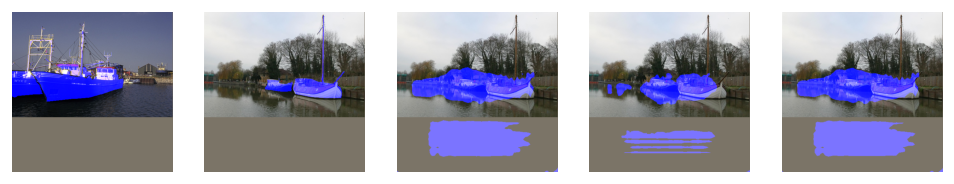

In [20]:
class Visualizer:
    def __init__(self, cfg, datasetloader, backbone, meta_model, mask_transparency=1.0, brightness=0, contrast=0, saturation=0, hue=0):
        assert datasetloader is not None

        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.cfg = cfg
        self.mask_transparency = mask_transparency
        self.color_aug = ColorAug(brightness, contrast, saturation, hue)

        self.datasetloader = datasetloader
        self.backbone = backbone
        self.meta_model = meta_model

    # Utility method for plotting a single image
    def plot(self, img):
        img = img.squeeze()

        if img.shape[0] == 3:
            plt.imshow(img.permute(1, 2, 0))
        elif len(img.shape) > 2:
            plt.imshow(img.mean(0))
        else:
            plt.imshow(img)

    def get_masked_image(self, img, mask, mode="B"):
        '''
        img: (H, W, 3)
        mask: (H, W)
        mode: 'R','G','B' red, green, blue
        '''
        mask = rearrange(mask, 'h w -> (h w)')
        mask[np.where(mask==255)[0]] = 0
        mask = rearrange(mask, '(h w) -> h w', h=473).unsqueeze(2)

        n = torch.zeros(mask.shape)
        if mode == 'R':
            new_img = torch.cat((mask, n, n), dim = 2)
        elif mode == 'G':
            new_img = torch.cat((n, mask, n), dim = 2)
        elif mode == 'B':
            new_img = torch.cat((n, n, mask), dim = 2)
        else:
            new_img = torch.cat((mask, n, n), dim = 2)
            raise RuntimeWarning("Mode should be 'R','G','B'; defaulting to use mode 'R'")
        
        new_img = new_img + img * self.mask_transparency
        
        return new_img

    # plot the next data batch
    def shownext(self, train=False):
        qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.datasetloader.next(train)


        s_label = s_label.squeeze()
        q_label = q_label.squeeze()

        spt_imgs = spt_imgs.squeeze()
        spt_imgs = rearrange(spt_imgs, 'c h w -> h w c')
        qry_img = qry_img.squeeze()
        qry_img = rearrange(qry_img, 'c h w -> h w c')

        q_path = q_info[0][0]
        spt_path = spt_info[0][0][0]

        masked_spt_im = self.get_masked_image(spt_imgs, s_label)
        # spt_im_aug, _ = self.color_aug(spt_imgs, None)

        img_list = [
            {'img': qry_img, 'label': f"Query Image"},
            {'img': spt_imgs, 'label': f"Original Support Image"},
            {'img': masked_spt_im, 'label': f"Support Image with Mask"},
            # {'img': torch.tensor(spt_im_aug), 'label': f"Transformed Support Image with setting {self.brightness}{self.contrast}{self.saturation}{self.hue}"},
        ]


        print(f"Support Info: {spt_info[0][0][0]}\nQuery Info: {q_info[0][0]}\n----------------------------------------------------------------------------------------------------")
        plt.figure(figsize=(10, 10*len(img_list)), dpi=120)

        for i in range(len(img_list)):
            print(img_list[i]['label'])
            plt.subplot(1, len(img_list), i+1)
            plt.axis('off')
            self.plot(img_list[i]['img'].permute(2,0,1))

    def show_prediction(self):

        qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.datasetloader.next()

        if torch.cuda.is_available():
            spt_imgs = spt_imgs.cuda()
            s_label = s_label.cuda()
            q_label = q_label.cuda()
            qry_img = qry_img.cuda()

        # ====== Phase 1: Train a new binary classifier on support samples. ======
        spt_imgs = spt_imgs.squeeze(0)
        s_label = s_label.squeeze(0).long()

        self.backbone.eval()
        with torch.no_grad():
            f_s, fs_lst = self.backbone.extract_features(spt_imgs)
            f_q, fq_lst = self.backbone.extract_features(qry_img)
        
        self.backbone.inner_loop(f_s, s_label)

        # ====== Phase 2: Update query score using attention. ======
        with torch.no_grad():
            pred_q0 = self.backbone.classifier(f_q)
            pred_q0 = F.interpolate(pred_q0, size=q_label.shape[1:], mode='bilinear', align_corners=True)

        self.meta_model.eval()

        with torch.no_grad():
            att_fq = []
            for k in range(self.cfg.shot * self.cfg.meta_aug):
                single_fs_lst = {key: [ve[k:k + 1] for ve in value] for key, value in fs_lst.items()}
                single_f_s = f_s[k:k + 1]
                _, att_out = self.meta_model(fq_lst, single_fs_lst, f_q, single_f_s, )
                att_fq.append(att_out)  # [ 1, 512, h, w]
            att_fq = torch.cat(att_fq, dim=0)
            att_fq = att_fq.mean(dim=0, keepdim=True)
            fq = f_q * (1 - self.cfg.att_wt) + att_fq * self.cfg.att_wt

        pd_q1 = self.backbone.classifier(att_fq)
        pred_q1 = F.interpolate(pd_q1, size=q_label.shape[-2:], mode='bilinear', align_corners=True)

        pred_q2 = F.softmax(pred_q0, dim=1)*(1 - self.cfg.att_wt) + F.softmax(pred_q1, dim=1)*self.cfg.att_wt

        pred0, pred1, pred2, spt_img, s_label, qry_img, q_label = pred_q0, pred_q1, pred_q2, spt_imgs, s_label, qry_img, q_label

        spt_img = rearrange(spt_img.squeeze().detach().cpu().numpy(), 'c h w -> h w c')
        qry_img = rearrange(qry_img.squeeze().detach().cpu().numpy(), 'c h w -> h w c')
        s_label = s_label.squeeze().detach().cpu().numpy()
        q_label = q_label.squeeze().detach().cpu().numpy()
        
        # remove 255 pixels
        q_label = rearrange(q_label, 'h w -> (h w)')
        q_label[np.where(q_label==255)[0]] = 0
        q_label = rearrange(q_label, '(h w) -> h w', h=473)
        q_label = torch.tensor(q_label)
        
        s_label = rearrange(s_label, 'h w -> (h w)')
        s_label[np.where(s_label==255)[0]] = 0
        s_label = rearrange(s_label, '(h w) -> h w', h=473)
        s_label = torch.tensor(s_label)
        

        # get pred0 mask
        fg0 = F.softmax(pred0, dim=1).squeeze().detach().cpu()
        mask0 = torch.argmax(fg0, dim=0)
        
        # get pred1 mask
        fg1 = F.softmax(pred1, dim=1).squeeze().detach().cpu()
        mask1 = torch.argmax(fg1, dim=0)

        # get pred2 mask
        fg2 = F.softmax(pred2, dim=1).squeeze().detach().cpu()
        mask2 = torch.argmax(fg2, dim=0)
        
        
        spt_ground_truth = self.get_masked_image(spt_img, s_label)
        query_ground_truth = self.get_masked_image(qry_img, q_label)
        query_mask_img0 = self.get_masked_image(qry_img, mask0)
        query_mask_img1 = self.get_masked_image(qry_img, mask1)
        query_mask_img2 = self.get_masked_image(qry_img, mask2)
        
        img_list = [spt_ground_truth, query_ground_truth, query_mask_img0, query_mask_img1, query_mask_img2]
        print(f"Support Info: {spt_info[0][0][0]}\nQuery Info: {q_info[0][0]}\n----------------------------------------------------------------------------------------------------")
        print(f"Support Ground Truth, Query Ground Truth, Query Prediction 0, Query Prediction 1, Query Prediction 2")
        plt.figure(figsize=(10, 10*len(img_list)), dpi=120)
        for i in range(len(img_list)):
            plt.subplot(1, len(img_list), i+1)
            plt.axis('off')
            plt.imshow(img_list[i])

    # reset the dataloader for Visualizer
    def reset_dataloader(self):
        self.datasetloader.reset()

test_vis = Visualizer(cfg, dataset_loader, model, Trans)
test_vis.show_prediction()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Support Info: /Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012/JPEGImages/2008_000120.jpg
Query Info: /Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012/JPEGImages/2007_000529.jpg
----------------------------------------------------------------------------------------------------
Support Ground Truth, Query Ground Truth, Query Prediction 0, Query Prediction 1, Query Prediction 2


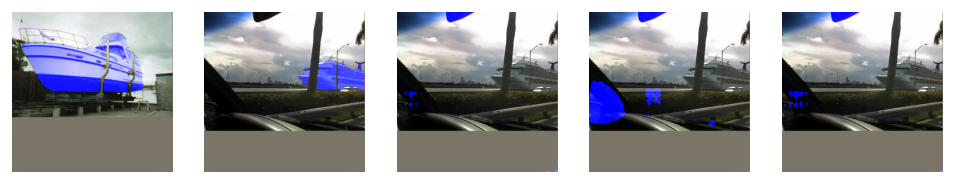

In [ ]:
test_vis.show_prediction()

In [ ]:
class Visualizer:

    '''
        Visualizer for displaying and saving visualizations

        Args:

            cfg (CfgNode): a JS Object like configuration instance for storing relevant configs

            datasetloader (DatasetLoader): dataset loader instance for iteratively accessing episodic data

            model (VisModelWrapper): a model instance that wraps backbone & meta model, providing useful accessing methods

            transparency (float): set transparency for original images, default to 1.0


        Attributes:

            cfg (CfgNode): a JS Object like configuration instance for storing relevant configs

            datasetloader (DatasetLoader): dataset loader instance for iteratively accessing episodic data

            model (VisModelWrapper): a model instance that wraps backbone & meta model, providing useful accessing methods

            transparency (float): set transparency for original images, default to 1.0


        Methods:

            shownext(self, train=False)
                plot the next batch of episodic data, default using data from validation loader
            
            showprediction(self, train=False)
                plot the prediction of next episodic data, default using data from validation loader
            
    '''

    def __init__(self, cfg: CfgNode, datasetloader: DatasetLoader, model: ModelWrapper, transparency: float):
        assert cfg is not None and type(cfg)==CfgNode, "cfg should not be None and should be an instance of class CfgNode"
        assert datasetloader is not None and type(datasetloader)==DatasetLoader, "datasetloader should not be None and should be an instance of class DatasetLoader"
        assert model is not None and type(model)==ModelWrapper, "model should not be None and should be an instance of class ModelWrapper"
        assert transparency is not None and type(transparency) in (float, int), "transparency should not be None and should be either integer OR float"

        self.cfg, self.datasetloader, self.model, self.transparency = cfg, datasetloader, model, transparency


    def _plot(self, img: torch.Tensor) -> None:

        '''
            Utility method for plotting a single image

            Args:

                img (torch.Tensor): an image of type torch.Tensor, shape should be (3, h, w) OR (h, w, 3)

            Returns: 

                None
        '''

        img = img.squeeze()

        if img.shape[0] == 3:
            plt.imshow(img.permute(1, 2, 0))
        else:
            plt.imshow(img)

    def _plot_list(self, img_list: list, spt_path: str, qry_path: str) -> None:

        '''
            Utility method for plotting a list of images

            Args:

                img_list (list): a list of dict, each instance contraining a dict like { 'img': <img_tensor>, 'label': <str_label> }

            Returns: 
            
                None
        '''

        print(f"Support Path: {spt_path}\nQuery Path: {qry_path}\n----------------------------------------------------------------------------------------------------")

        plt.figure(figsize=(10, 10*len(img_list)), dpi=120)

        for i in range(len(img_list)):
            print(img_list[i]['label'])
            plt.subplot(1, len(img_list), i+1)
            plt.axis('off')
            self._plot(img_list[i]['img'])


    def _get_masked_image(self, img: torch.Tensor, mask: torch.Tensor, mode="B") -> torch.Tensor:

        '''
            Utility method for getting an image with specified mask

            Args:

                img (torch.Tensor): an image of type torch.Tensor, shape should be (h, w, 3)

                mask (torch.Tensor): a mask of type torch.Tensor, shape should be (h, w)

                mode (str): 'R','G','B' red, green, blue

            Returns:

                masked_img (torch.Tensor): a new image with mask applied

            Raises:

                RuntimeWarning: Mode should be 'R','G','B'; defaulting to use mode 'R'
        '''

        assert len(img.shape) == 3 and len(mask.shape) == 2, "Img/Mask shape invalid"

        mask = rearrange(mask, 'h w -> (h w)')
        mask[torch.where(mask==255)[0]] = 0
        mask = rearrange(mask, '(h w) -> h w', h=473).unsqueeze(2)

        n = torch.zeros(mask.shape)

        if mode == 'R':
            mask = torch.cat((mask, n, n), dim = 2)
        elif mode == 'G':
            mask = torch.cat((n, mask, n), dim = 2)
        elif mode == 'B':
            mask = torch.cat((n, n, mask), dim = 2)
        else:
            mask = torch.cat((mask, n, n), dim = 2)
            raise RuntimeWarning("Mode should be 'R','G','B'; defaulting to use mode 'R'")
        
        masked_img = mask + img * self.mask_transparency
        
        return masked_img

    def shownext(self, train=False):
        '''
            Displaying next episode images

            Args:

                train (bool): whether to use data from train loader
        '''

        qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.datasetloader.next(train)

        s_label = s_label.squeeze()
        q_label = q_label.squeeze()

        spt_imgs = spt_imgs.squeeze()
        spt_imgs = rearrange(spt_imgs, 'c h w -> h w c')
        qry_img = qry_img.squeeze()
        qry_img = rearrange(qry_img, 'c h w -> h w c')

        qry_path = q_info[0][0]
        spt_path = spt_info[0][0][0]

        masked_spt_im = self.get_masked_image(spt_imgs, s_label)

        img_list = [
            {'img': qry_img, 'label': f"Query Image"},
            {'img': spt_imgs, 'label': f"Original Support Image"},
            {'img': masked_spt_im, 'label': f"Support Image with Mask"},
        ]

        self._plot_list(img_list, spt_path, qry_path)


    def search(self, threshold: float, num_episodes: int, save_path: str) -> None:

        '''
            Search from validation data and retain episodes that satisfy required decision threshold

            Args:

                threshold (float): decision threshold -- episodes that satisfies `MAX(pred1-pred0, pred2-pred0) > threshold` will be retained

                num_episodes (int): number of episodic data to test before stop

            Raises:

                AssertionError: type does not match/tensor shape does not match

                RuntimeError: Any

            Returns:

                None
        '''
        pass

